## Sberbank Data Visualization Using Seaborn

This notebook is for doing some basic data visualization of the sberbank dataset features. The aim is to identify trends/patterns that can be used for feature engineering or to plug potential blindspots for the downstream regressor. This exercise also helps identify outliers in crucial variables.

<b>Seaborn</b> is the choice tool for this task owing to ease of use and pretty outputs as opposed to vanilla matplotlib.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

### Read the datasets

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
macro = pd.read_csv('macro.csv')

#x = x[x['full_sq'] <= 450]
#x = x[x['price_doc'] < 100000000]

### Variables of Interest

The independent variable to be predicted is the price_doc variable. It is reported in Rubles and hence can reach very large values. We will be using a scale-down factor later for easier handling.

We can assume that the price of an apartment would primarily depend on the following:

1. Size of the apartment
2. Number of rooms
3. The floor the apartment is on
4. Locality - some areas command a higher price even for smaller houses
5. Connectivity - distance to subway stations, airports, bus stations etc
6. Convenience: Distance to offices, shopping centers, parks, restaurants etc
7. Current market dynamics


### Distribution of the prices

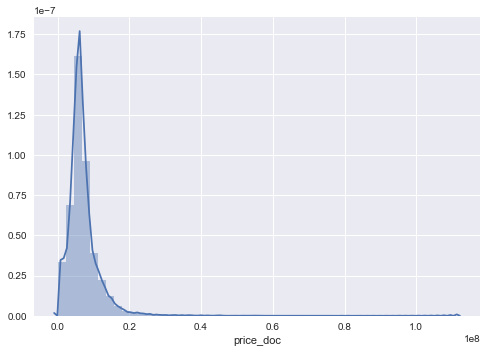

In [3]:
sns.distplot(train['price_doc'],kde=True)
plt.show()

The x-axis is hard to understand here (the scale is from 0 to 1e8). I would prefer working in units of millions for the prices

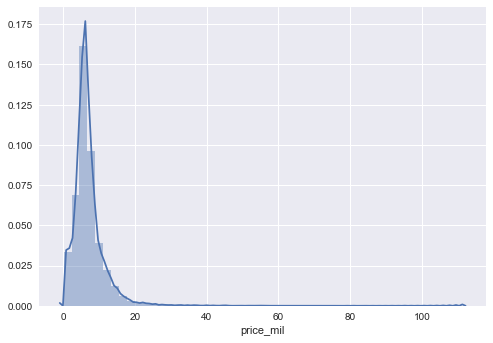

In [4]:
train['price_mil'] = train['price_doc']/1000000 #Let's add this to the dataframe as well
sns.distplot(train['price_mil'],kde=True)
plt.show()

Most apartments cost below 10M Rubles. A select few are higher than 20M Rubles.
Let's look at the distribution of the apartment sizes as well.

### Apartment total area (full_sq) distribution 

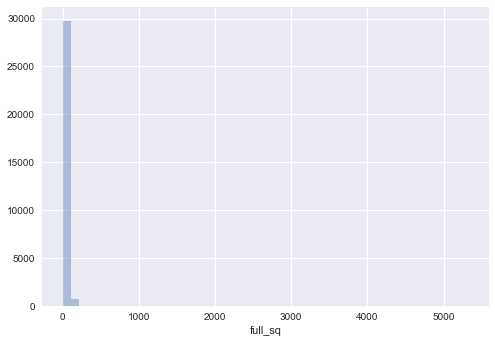

In [5]:
sns.distplot(train['full_sq'],kde=False)
plt.show()

It appears that there are outliers in the data which mess up the distribution. Let's see what are the 10 highest floor area values:

In [6]:
train_full_sq, test_full_sq = np.array(train['full_sq']), np.array(test['full_sq'])
print('train:',np.sort(train_full_sq)[-10:])
print('test:',np.sort(test_full_sq)[-10:])

train: [ 394  407  412  461  603  634  634  637  729 5326]
test: [ 186.9  189.1  197.   198.4  219.6  232.7  282.   285.8  314.5  403. ]


The test file only has one sample with full_sq > 400 but the training set has many which are higher. Also the one sample above 5000 is messing up our chart. It makes sense to discard training samples which have full_sq > 403. It would make things easier for the downstream regression model as well.

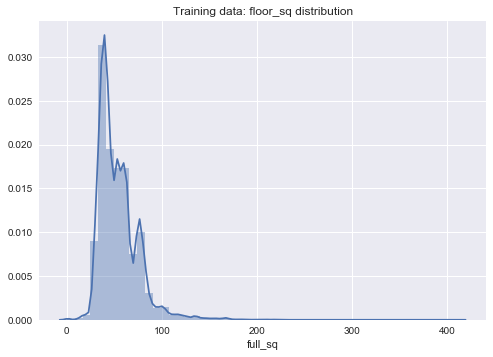

In [7]:
train = train[train['full_sq'] <= 450] #discarding samples with full_sq > 450
train_full_sq, test_full_sq = np.array(train['full_sq']), np.array(test['full_sq'])
sns.distplot(train['full_sq'],kde=True)
plt.title('Training data: floor_sq distribution')
plt.show()

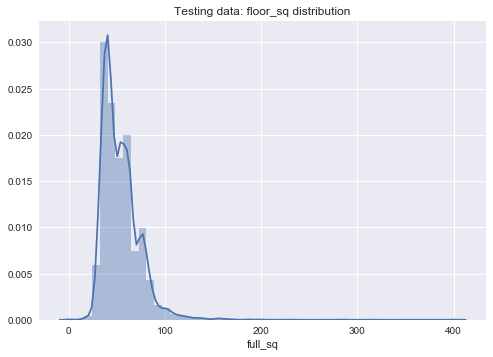

In [8]:
sns.distplot(test['full_sq'],kde=True)
plt.title('Testing data: floor_sq distribution')
plt.show()

Let's compare the densities of the full_sq varibales in the train and test file:

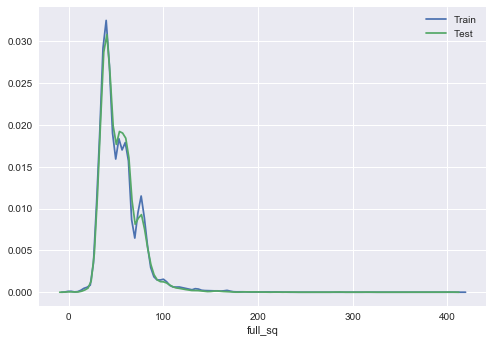

In [9]:
sns.distplot(train['full_sq'],kde=True, hist=False, label="Train")
sns.distplot(test['full_sq'],kde=True, hist=False, label="Test")
plt.show()

The KDEs look fairly similar for the training and the testing set. That's good. Now let's look at the price of each square foot of real estate.

### Price per unit area (per sq meter or sq foot)

We can obtain price per unit area by dividing the price_doc by full_sq. Before we do that, we need to ensure that we don't end up dividing by 0 anywhere. Let's look at the 30 lowest full_sq values:

In [10]:
print('train:',np.sort(train_full_sq)[:30])
print('test:',np.sort(test_full_sq)[:30])

train: [ 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  5  6  9 10]
test: [  0.     1.     2.    10.    14.8   15.8   15.9   16.8   17.1   17.2   17.4
  17.5   18.2   18.7   19.2   19.91  20.1   20.5   20.8   22.    22.2   22.3
  22.4   22.5   22.5   22.5   22.6   22.8   22.9   23.4 ]


There are a few samples with full_sq = 0 in both training and testing datasets. Since this variable is the most important for estimating the price, we need to handle these cases carefully. For the training set, let's discard all samples with full_sq < 10. For the test set, we will floor the full_sq to 10. Since there are only 3 datapoints in test set with full_sq < 10, we won't have significant problems.

In [11]:
train = train[train['full_sq'] >= 10] #discarding samples with full_sq < 10
test_full_sq[test_full_sq<10]=10
test['full_sq']=test_full_sq
train_full_sq, test_full_sq = np.array(train['full_sq']), np.array(test['full_sq']) # Reassign these
print('train:',np.sort(train_full_sq)[:30])
print('test:',np.sort(test_full_sq)[:30])

train: [10 11 12 12 12 12 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 15 15 15
 15 15 15 15 15]
test: [ 10.    10.    10.    10.    14.8   15.8   15.9   16.8   17.1   17.2   17.4
  17.5   18.2   18.7   19.2   19.91  20.1   20.5   20.8   22.    22.2   22.3
  22.4   22.5   22.5   22.5   22.6   22.8   22.9   23.4 ]


Let's compute our price per unit area now and look at it's distribution

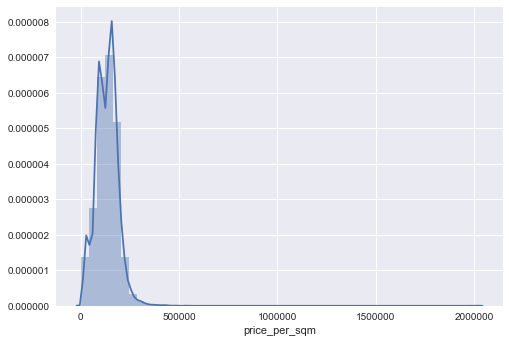

In [12]:
train['price_per_sqm'] = train['price_doc']/train['full_sq']
sns.distplot(train['price_per_sqm'],kde=True)
plt.show()

The distribution has a long tail to the right and that really bothers me. Let's look at the top 20 samples on the right.

In [13]:
print('train:',np.sort(train['price_per_sqm'])[-20:])

train: [  432374.98181818   435000.           435483.87096774   436445.02325581
   439007.82608696   439837.70542636   440000.           443806.68421053
   451612.90322581   453846.15384615   459864.82758621   471851.81456954
   478432.25806452   481820.76595745   490445.85987261   492249.16756757
   532545.94059406   539393.93939394   541666.66666667  2020202.03636364]


There is one sample which is 4 times as high as the second highest one. Let's discard that and plot again.

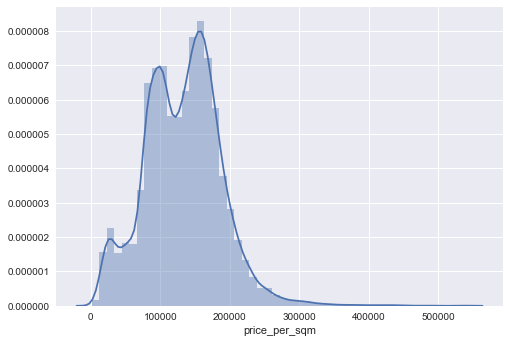

In [14]:
train = train[train['price_per_sqm'] < 2000000]
sns.distplot(train['price_per_sqm'],kde=True)
plt.show()

There are two peaks in this distribution. It would be useful to uncover what factors result in that. Locality might be the best guess. Houses in the city center v/s suburbs maybe?

#### Price per sq meter (or sq feet) would be our primary independent variable. This is because it scales better than price across different parameters. A house in in a premium locale with lots of amenities and good connectivity would command a higher price per sq meter as opposed to others. This logical extension is easier to establish with price per sq meter as opposed to just price.

## Price per sq meter as a function of other parameters 

### 0. Area of the apartment itself

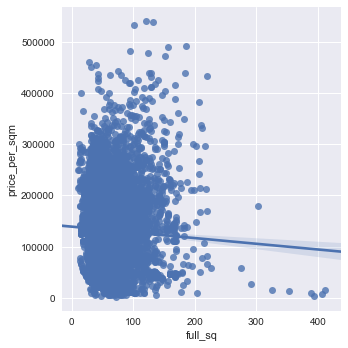

In [15]:
sns.lmplot(x="full_sq", y="price_per_sqm", data=train)
plt.show()

The price per unit area seems to go down as the size increses. But the plot doesn't say much really. It is more informative to look at the average price across different floor areas along with their deviations.

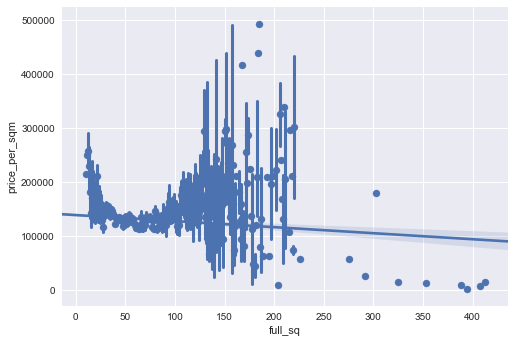

In [16]:
sns.regplot(x="full_sq", y="price_per_sqm", data=train,  x_estimator=np.mean)
plt.show()

Plotting just the houses with areas < 250 might be more helpful

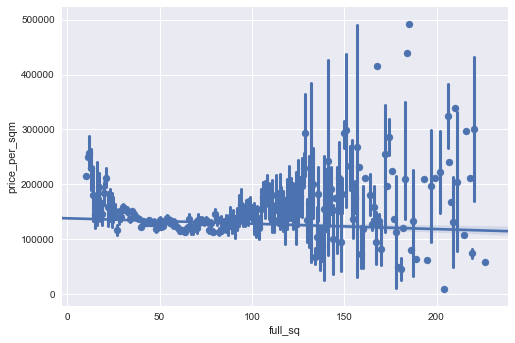

In [17]:
sns.regplot(x="full_sq", y="price_per_sqm", data=train[train['full_sq']<250],  x_estimator=np.mean)
plt.show()

Now if we recall what we observed a few charts above, most houses are <100sqm and this is the range where the prices do not have a large deviation. It is certainly a lot more difficult to predict the prices of larger houses - not only do they vary wildly but there are far fewer data points for them. 

### 1. Product type: Investment vs Owner Occupied

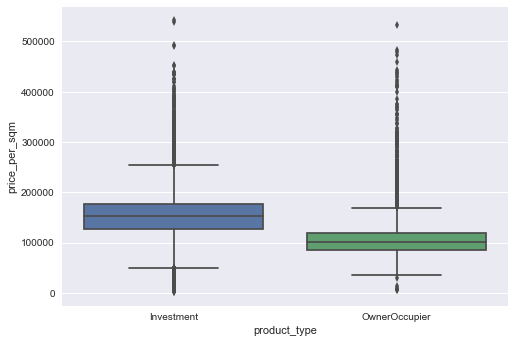

In [18]:
sns.boxplot(x="product_type", y="price_per_sqm", data=train)
plt.show()

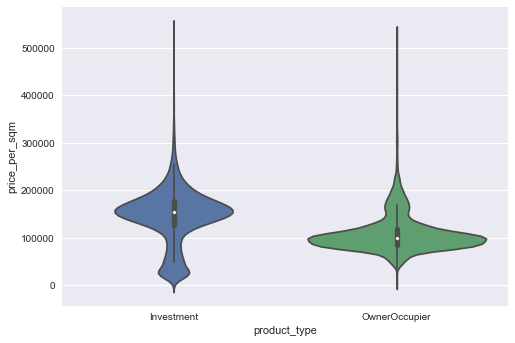

In [19]:
sns.violinplot(x="product_type", y="price_per_sqm", data=train)
plt.show()

Investments command a significant premium over owner occupied places. This would explain the two peaks in the price_per_sqm histogram. Let's check it out.

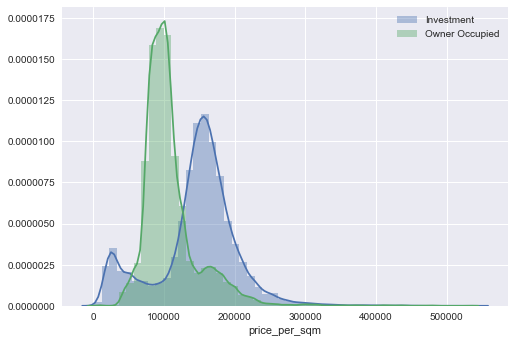

In [20]:
train_investment = train[train['product_type']=="Investment"]
train_OwnerOccupier = train[train['product_type']=="OwnerOccupier"]
sns.distplot(train_investment['price_per_sqm'],kde=True, label="Investment")
sns.distplot(train_OwnerOccupier['price_per_sqm'],kde=True,label = "Owner Occupied")
plt.legend()
plt.show()

As expected, the Owner occupied houses have a peak at a lower price_per_sqm resulting in twin peaks for the overall distribution. Investments also have a smaller peak at a much lower value - low cost investments?

### 2. Floor

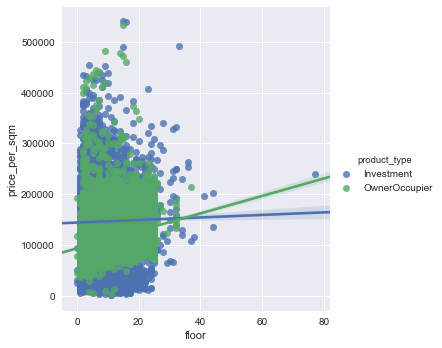

In [21]:
sns.lmplot(x="floor", y="price_per_sqm", hue="product_type", data=train)
plt.show()

Lets get rid of that lone outlier point and plot again.

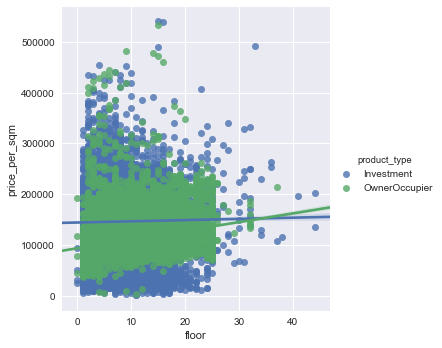

In [22]:
train = train[train['floor'] < 60]
sns.lmplot(x="floor", y="price_per_sqm", hue="product_type", data=train)
plt.show()

The owner occupied houses show a gradual uptrend. Investment houses seem to be all over the place. Let's look at the same plot but now with the <b>mean</b> price_per_sqm for each floor.

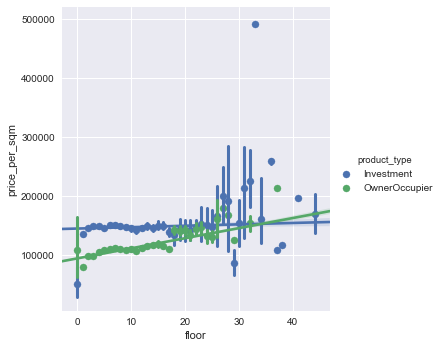

In [23]:
sns.lmplot(x="floor", y="price_per_sqm", hue="product_type", data=train, x_estimator=np.mean)
plt.show()

Floor does seem like a variable that has some predictive power but not as much as product_typ or area.

### 3. State (condition) of the house

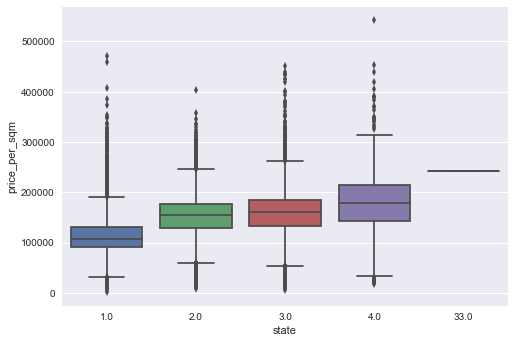

In [24]:
sns.boxplot(x="state", y="price_per_sqm", data=train)
plt.show()

These states, although categorical, appear to be <b>ordinal</b>. 4 > 3 > 2 > 1. That 33 looks like a data entry error. Let's dump that and re-draw the chart, this time also considering the product_type.

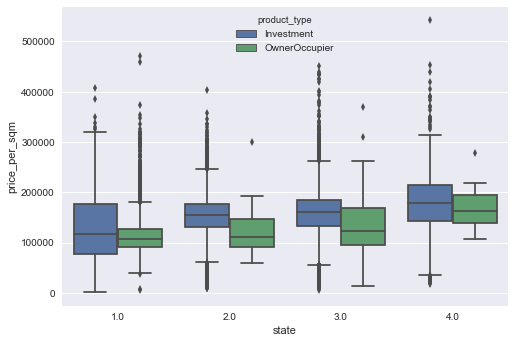

In [25]:
train = train[train['state'] < 5]
sns.boxplot(x="state", y="price_per_sqm", hue="product_type", data=train)
plt.show()

The trend is clear with owner occupied houses but it is not as significant for Investments.

### 4. Build year

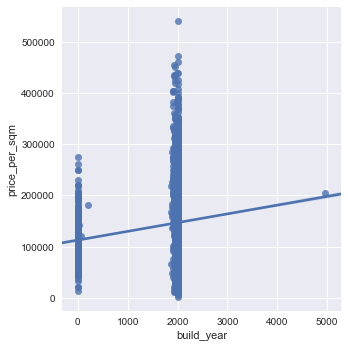

In [26]:
sns.lmplot(x="build_year", y="price_per_sqm", data=train)
plt.show()

Would be helpful to re-draw the chart after removing the 5000AD house and all the ones with reported build_year as 0

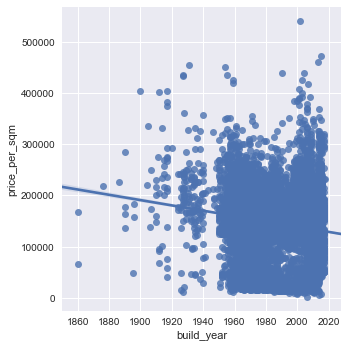

In [27]:
sns.lmplot(x="build_year", y="price_per_sqm", data=train[(train['build_year'] < 2100) & ((train['build_year'] > 1000))])
plt.show()

Vintage value much? I would have expected newer houses to be more expensive. This is counter-intuitive to me but whatever. Perhaps the houses near the city center are older and the ones in the suburbs or outskirts are relatiely newer ones.

Let's look at the mean prices by year and only for houses built after 1945 (WW2) - that's where all the volumes are.

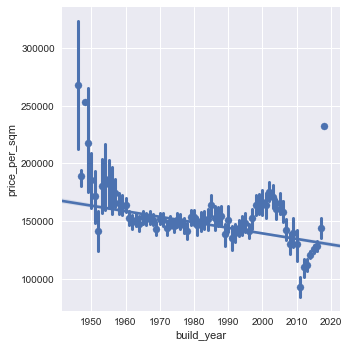

In [28]:
sns.lmplot(x="build_year", y="price_per_sqm", x_estimator=np.mean,data=train[(train['build_year'] < 2100) & ((train['build_year'] > 1945))])
plt.show()

Wonder why houses built in 2009-2012 are so cheap?

### 5. Number of rooms

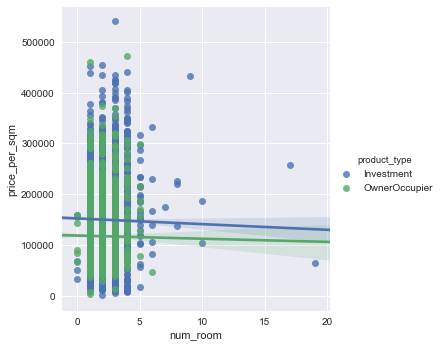

In [29]:
sns.lmplot(x="num_room", y="price_per_sqm", hue="product_type", data=train)
plt.show()

The regression lines suggest a mild downward trend. Not significant though.

### 6. Material

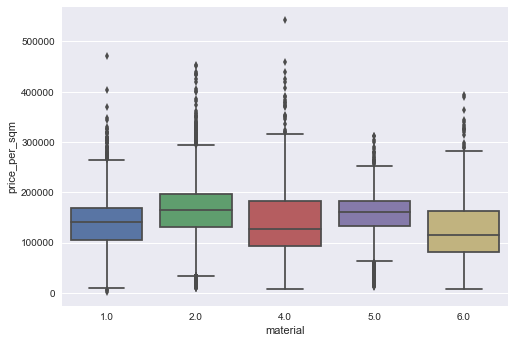

In [30]:
sns.boxplot(x="material", y="price_per_sqm", data=train)
plt.show()

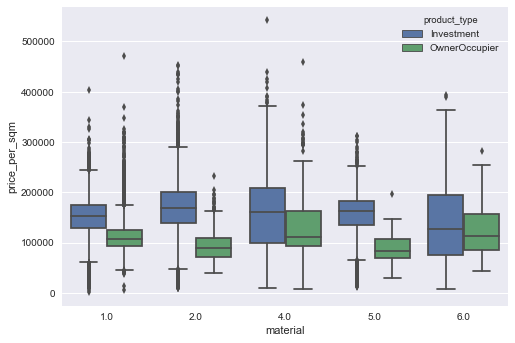

In [31]:
sns.boxplot(x="material", y="price_per_sqm", hue="product_type",data=train)
plt.show()

Seems like a useful variable (at least by looking at the median values). It is easy to note that the material numbering is not ordinal. Material 2 appears to be the best of the lot.

### 7. Kitchen Size

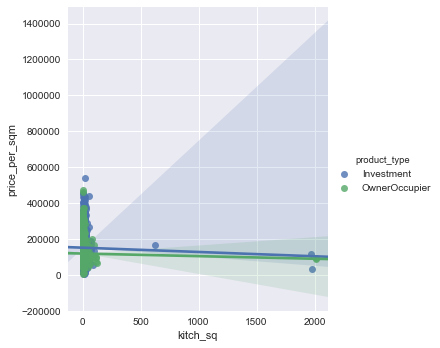

In [32]:
sns.lmplot(x="kitch_sq", y="price_per_sqm", hue="product_type", data=train)
plt.show()

Those outliers need to go

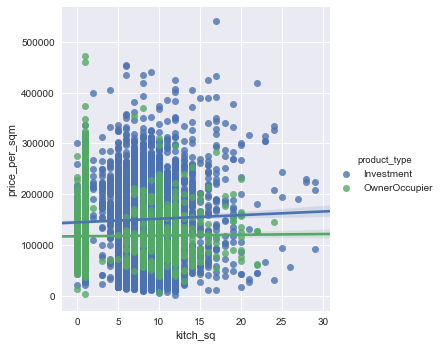

In [33]:
sns.lmplot(x="kitch_sq", y="price_per_sqm", hue="product_type", data=train[train['kitch_sq']<30])
plt.show()

There seems to be a mild correlation but nothing concrete

### 8. Distance from City Center (The Kremlin?)

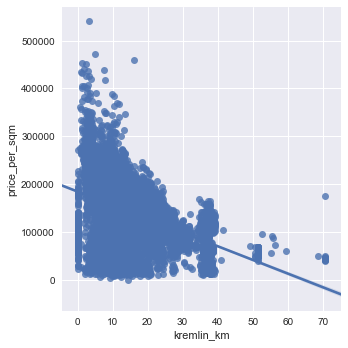

In [34]:
sns.lmplot(x="kremlin_km", y="price_per_sqm", data=train)
plt.show()

sns.lmplot(x="kremlin_km", y="price_per_sqm", data=train, x_estimator=np.mean)
plt.show()

No surprises here. Closer to Kremlin is more expensive, as indicated by the linear regressor

### 9. Locality

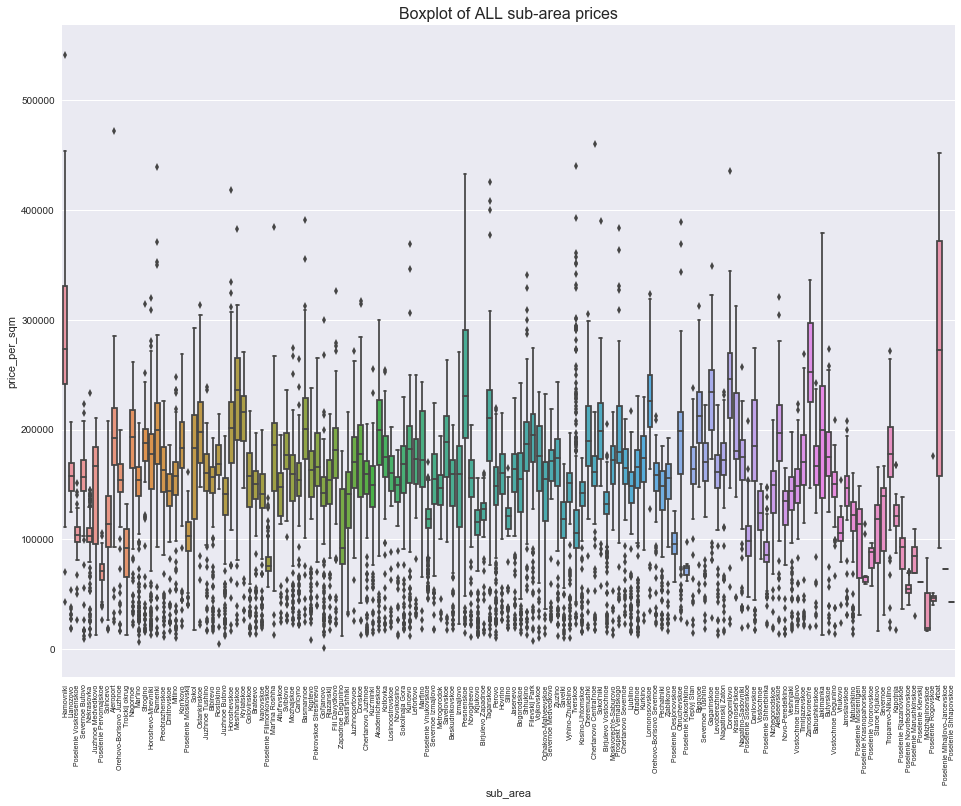

In [35]:
f, ax = plt.subplots(figsize=(16, 12))
sns.boxplot(x="sub_area", y="price_per_sqm", data=train)
plt.title("Boxplot of ALL sub-area prices", fontsize=16)
plt.xticks(rotation=90, fontsize=7)
plt.show()

Okay, Bad idea. There are too many sub-areas and it's hard to make sense of the chart. Let's only look at areas with the most apartment sales and focus on those.

In [36]:
from collections import Counter
area_count = Counter(np.array(train['sub_area'])).most_common(10)
print(area_count)

[('Nekrasovka', 740), ('Poselenie Sosenskoe', 570), ('Poselenie Vnukovskoe', 543), ('Mitino', 375), ('Tverskoe', 370), ("Mar'ino", 350), ('Poselenie Moskovskij', 311), ('Juzhnoe Butovo', 301), ('Poselenie Filimonkovskoe', 267), ('Nagatinskij Zaton', 254)]


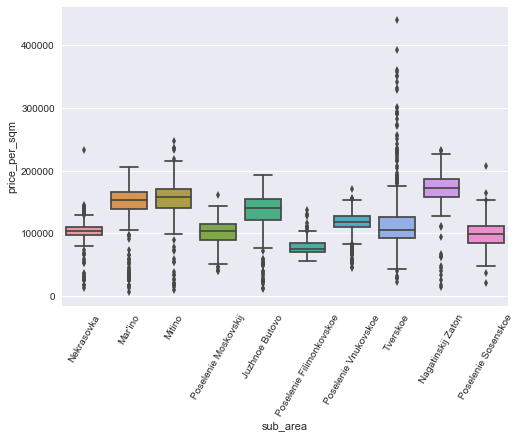

In [37]:
popular_areas = [x[0] for x in area_count]
sns.boxplot(x="sub_area", y="price_per_sqm", data=train[train['sub_area'].isin(popular_areas)])
plt.xticks(rotation=60)
plt.show()

This chart makes it obvious that locality plays an important role. The area "Tverskoe" looks pretty interesting. Although the median is low, it has a really tall wick on the top. It clearly houses some of the most expensive real estate in the city.

Let's look at the average distance from kremlin for these 10 sub-areas and see if there's a pattern - especially Tverskoe

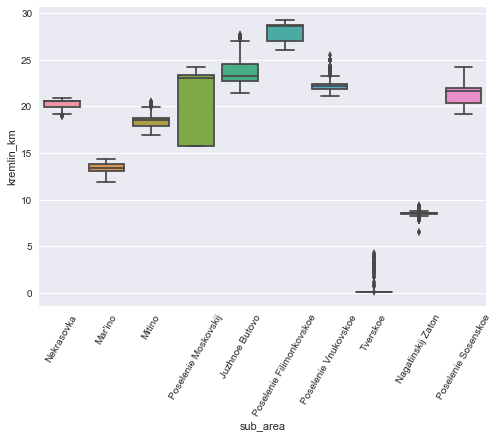

In [38]:
sns.boxplot(x="sub_area", y="kremlin_km", data=train[train['sub_area'].isin(popular_areas)])
plt.xticks(rotation=60)
plt.show()

No surprises again -- Tverskoe is the area closest to Kremlin amongst these 10. 

I am also interested in knowing how the localities fare in train vs test

In [39]:
# Get the counts of each sub area for train and test
train_area_count = Counter(np.array(train['sub_area']))
test_area_count = Counter(np.array(test['sub_area']))
# Convert these to data frames
train_area_df = pd.DataFrame({'sub_area':[x[0] for x in train_area_count.items()], 'train_count':[x[1] for x in train_area_count.items()]})
test_area_df = pd.DataFrame({'sub_area':[x[0] for x in test_area_count.items()], 'test_count':[x[1] for x in test_area_count.items()]})
# Do an outer join of the two to ensure no uncommon sub areas are missed out
merged_area_df = pd.merge(train_area_df, test_area_df, how='outer', on='sub_area')
# Verify if all the areas are common to both train and test
print('train:', len(train_area_df),'test:', len(test_area_df), 'merged:', len(merged_area_df),'\n')
# Sort by train occurance
merged_area_df.sort_values(by=['train_count'], axis=0, ascending=False, inplace=True)
# Print the first 10 rows
print(merged_area_df.head(10))

train: 145 test: 145 merged: 145 

                     sub_area  train_count  test_count
4                  Nekrasovka          740          99
111       Poselenie Sosenskoe          570         297
59       Poselenie Vnukovskoe          543         584
18                     Mitino          375         173
83                   Tverskoe          370         181
12                    Mar'ino          350         125
20       Poselenie Moskovskij          311         229
26             Juzhnoe Butovo          301         118
33   Poselenie Filimonkovskoe          267          28
107         Nagatinskij Zaton          254         244


Looks like the distribution across sub areas are very different in train and test

I still want to go back to a chart with all the areas and their distance from the city center. I am also curious to know how big these sub-areas are. Let's use Pandas for some SQL-like grouping and averaging to get there.

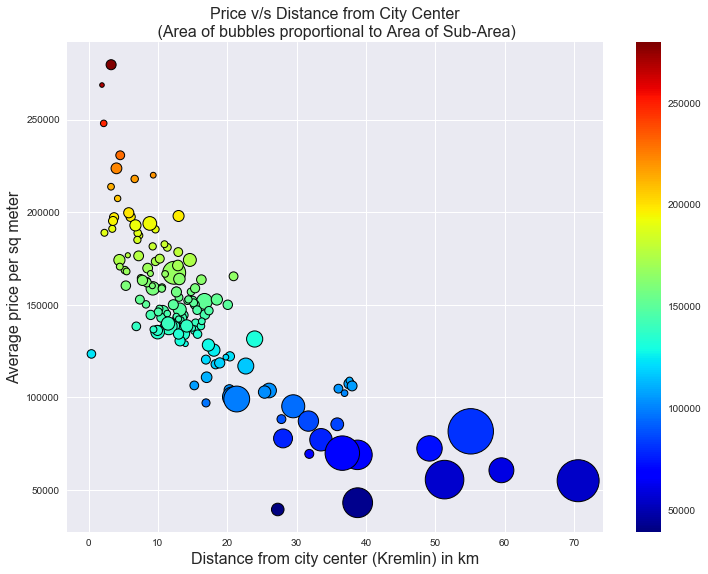

In [40]:
area_df = train[['sub_area','price_per_sqm','kremlin_km','area_m']]
area_df['count'] = 1
area_group = area_df.groupby(['sub_area']).agg({'price_per_sqm':'mean', 'kremlin_km':'mean', 'area_m':'mean', 'count':'sum'})
area_group['sub_area'] = np.array(area_group.index)
import matplotlib.cm as cm
plt.figure(figsize=(12,9))
sc =plt.scatter(x=area_group['kremlin_km'], y=area_group['price_per_sqm'],
            s=area_group['area_m']/100000, c=area_group['price_per_sqm'], 
            cmap = cm.jet, edgecolor='black', linewidth='1', marker='o')
plt.xlabel("Distance from city center (Kremlin) in km", fontsize=16)
plt.ylabel("Average price per sq meter", fontsize=16)
plt.title("Price v/s Distance from City Center\n (Area of bubbles proportional to Area of Sub-Area)", fontsize=16)
plt.colorbar(sc)
plt.show(sc)

The expensive sub-areas are closer to Kremlin compared to the cheaper ones (whith a few exceptions). Sub-areas further from the center tend to be much larger, which is expected in a radially expanding city.

### 10. Ecology

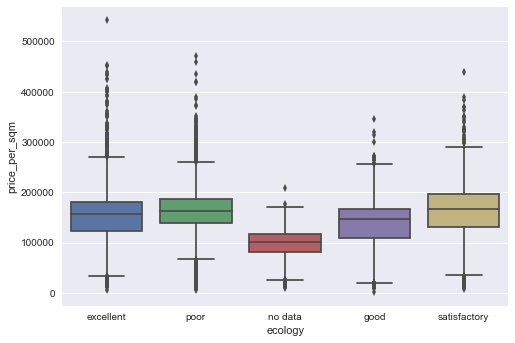

In [41]:
sns.boxplot(x="ecology", y="price_per_sqm", data=train)
plt.show()

"No data" seems to matter. All the others don't.

### 11. Being surrounded by cafes

The datasets have LOT of columns about cafes nearby. Is it that important in Russia?

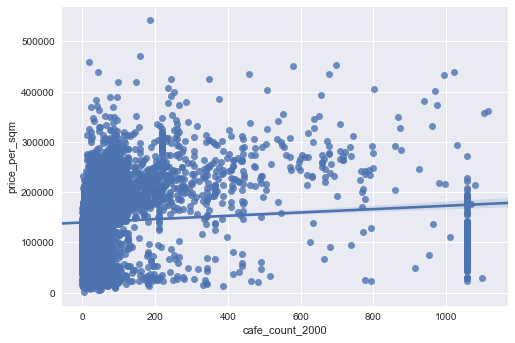

In [42]:
sns.regplot(x="cafe_count_2000", y="price_per_sqm", data=train)
plt.show()

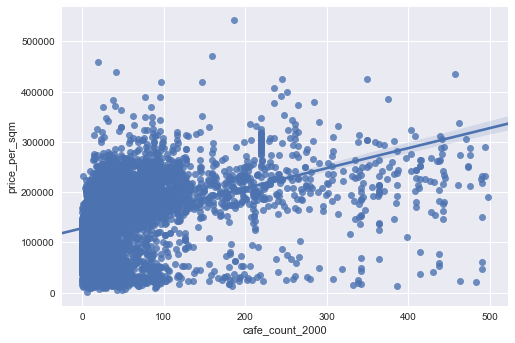

In [43]:
sns.regplot(x="cafe_count_2000", y="price_per_sqm", data=train[train['cafe_count_2000']<500])
plt.show()

Seems to matter a lot. But I still think there are too many of these variables and they may be highly correlated. Some of them need to go. We'll look at this later.

### 12. Time of purchase??

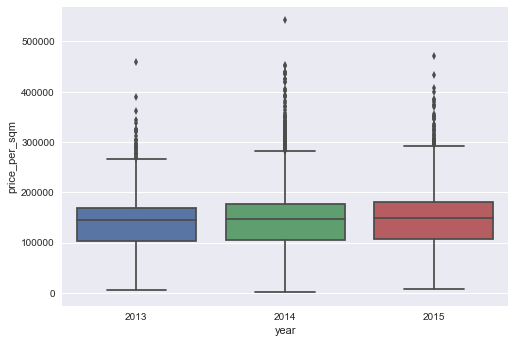

In [44]:
date = np.array(train['timestamp'])
month = np.array([int(p.split('-')[1]) for p in date])
year = np.array([int(p.split('-')[0]) for p in date])
train['month'] = month
train['year'] = year
sns.boxplot(x="year", y="price_per_sqm", data=train)
plt.show()

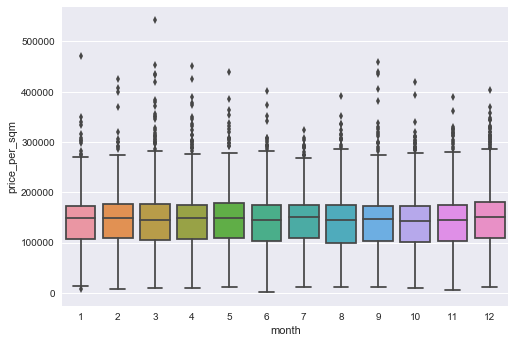

In [45]:
sns.boxplot(x="month", y="price_per_sqm", data=train)
plt.show()

Nope. Nothing significant here. Should drop the year and month while training model. The macro economics data set might give us something

### 13. Ratio of life_sq to full_sq

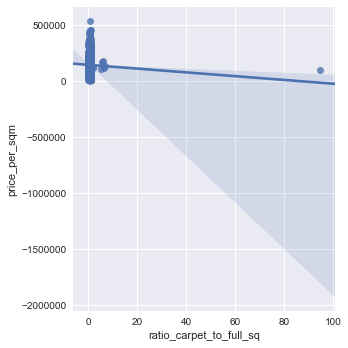

In [46]:
train['ratio_carpet_to_full_sq'] = train['life_sq']/train['full_sq']
sns.lmplot(x="ratio_carpet_to_full_sq", y="price_per_sqm", data=train)
plt.show()

I believe that life_sq cannot be greater than full_sq. This data set has a phenomenal number of data entry errors. Plotting again considering only those houses with life_sq < full_sq 

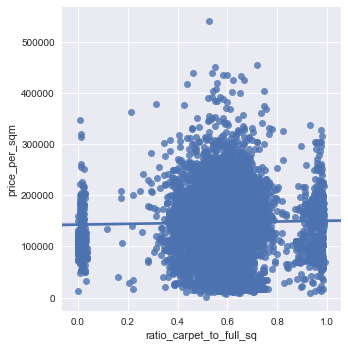

In [47]:
sns.lmplot(x="ratio_carpet_to_full_sq", y="price_per_sqm", data=train[train['ratio_carpet_to_full_sq'] < 1])
plt.show()

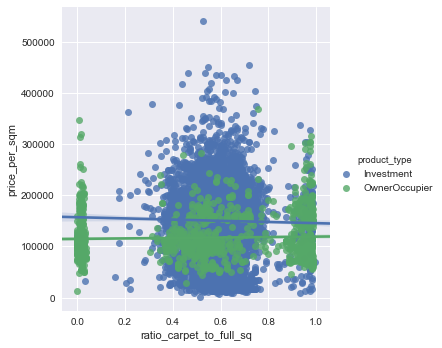

In [48]:
sns.lmplot(x="ratio_carpet_to_full_sq", y="price_per_sqm", hue="product_type",data=train[train['ratio_carpet_to_full_sq'] < 1])
plt.show()

The variable matters more for owner occupied than investments. 

## So many Cafes

Total Cafe Variables: 66


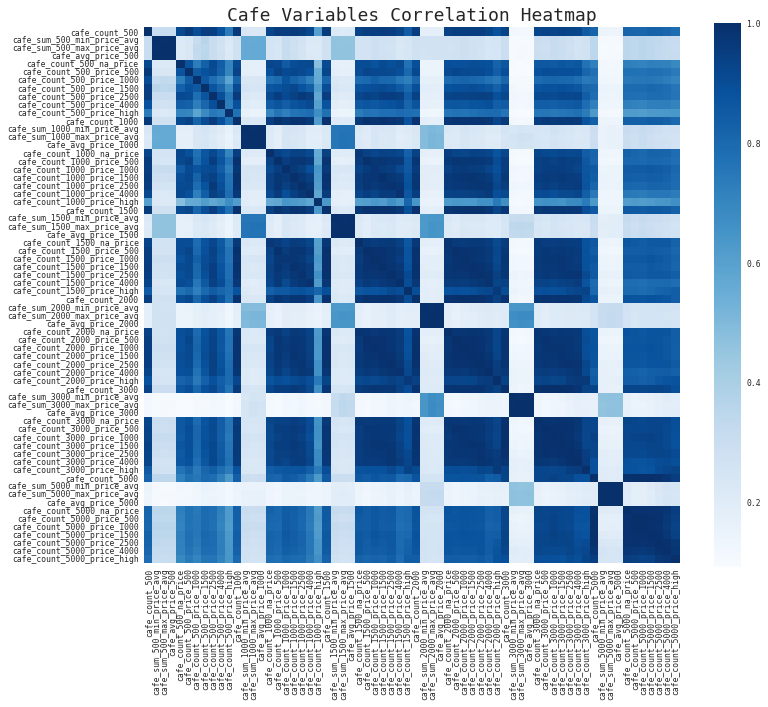

In [49]:
# List out the cafe variables and create a new dataframe for them
cafe_variables = [x for x in list(train) if 'cafe' in x]
print("Total Cafe Variables:", len(cafe_variables))
train_cafe = train[cafe_variables]
train_cafe = train_cafe.fillna(0)
# Correlation Matrix
cafe_corr = train_cafe.corr()
# Set up the matplotlib figure
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 10))
# Draw the heatmap
sns.heatmap(cafe_corr, vmax=1.0, square=True, cmap="Blues")
plt.title("Cafe Variables Correlation Heatmap", fontsize=18)
plt.show()

Am I the only one who finds this colormap so cool?? Look at those grids!! 

Looking at the heatmap, most of the variables appear to be highly correlated. Few of them are uncorrelated though. This may perhaps be one of those rare ocassions where <b>Principal Component Analysis (PCA)</b> might actually add value (Yes I am not a very big fan of PCA. Don't judge me for it)  

In [50]:
from sklearn.decomposition import PCA
#Let's see how many principal components are needed for capturing different amounts of variance in the data
pca50, pca90, pca95, pca99, pca9999 = PCA(n_components=0.5,whiten=True),PCA(n_components=0.9,whiten=True),PCA(n_components=0.95,whiten=True), PCA(n_components=0.99,whiten=True),PCA(n_components=0.9999,whiten=True)
pca50.fit(train_cafe), pca90.fit(train_cafe), pca95.fit(train_cafe), pca99.fit(train_cafe), pca9999.fit(train_cafe)
print("PCs needed for 50% of variance:",np.shape(pca50.components_)[0])
print("PCs needed for 90% of variance:",np.shape(pca90.components_)[0])
print("PCs needed for 95% of variance:",np.shape(pca95.components_)[0])
print("PCs needed for 99% of variance:",np.shape(pca99.components_)[0])
print("PCs needed for 99.99% of variance:",np.shape(pca9999.components_)[0])

PCs needed for 50% of variance: 1
PCs needed for 90% of variance: 4
PCs needed for 95% of variance: 6
PCs needed for 99% of variance: 7
PCs needed for 99.99% of variance: 16


I'll stick to 6 Principal Components to capture 95% of the variance. One may even choose to have just 1 PC or have 16 or even more. Depends on your appetite for information loss. Now let's go ahead and do the actual dimensionality reduction.

In [51]:
train_cafe_pcs = pca95.transform(train_cafe)
#train = train.drop(cafe_variables, axis=1)
train = train.assign(cafe_PC1= train_cafe_pcs[:,0], cafe_PC2=train_cafe_pcs[:,1], 
                     cafe_PC3=train_cafe_pcs[:,2], cafe_PC4=train_cafe_pcs[:,3],
                     cafe_PC5=train_cafe_pcs[:,4], cafe_PC6=train_cafe_pcs[:,5])

While we're at it, let's see how these PCs correlate with our independent variable

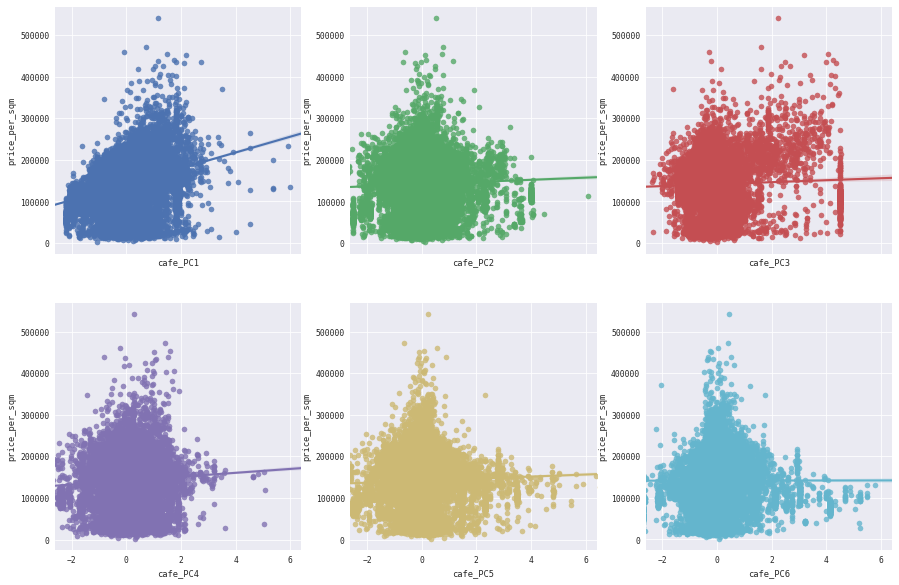

In [52]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
sns.regplot(x="cafe_PC1", y="price_per_sqm", data=train, ax=axes[0, 0])
sns.regplot(x="cafe_PC2", y="price_per_sqm", data=train, ax=axes[0, 1])
sns.regplot(x="cafe_PC3", y="price_per_sqm", data=train, ax=axes[0, 2])
sns.regplot(x="cafe_PC4", y="price_per_sqm", data=train, ax=axes[1, 0])
sns.regplot(x="cafe_PC5", y="price_per_sqm", data=train, ax=axes[1, 1])
sns.regplot(x="cafe_PC6", y="price_per_sqm", data=train, ax=axes[1, 2])
plt.show()

There is a decent correlation between cafe_PC1 and the price_per_sqm. We have also managed to bring down the variables from 66 to 6.

### What about office and TRC?

Total Office Variables: 14


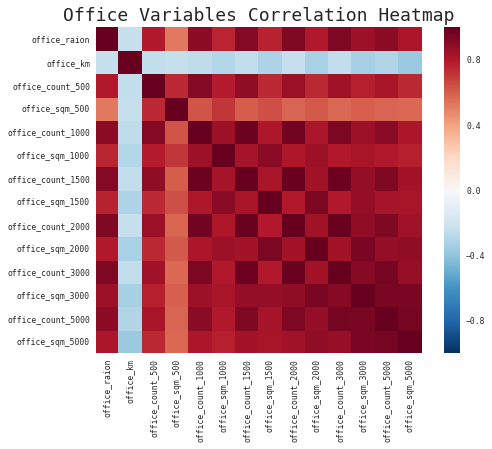

In [53]:
# List out the office variables and create a new dataframe for them
office_variables = [x for x in list(train) if 'office' in x]
print("Total Office Variables:", len(office_variables))
train_office = train[office_variables]
train_office = train_office.fillna(0)
# Correlation Matrix
office_corr = train_office.corr()
# Set up the matplotlib figure
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(8, 6))
# Draw the heatmap
sns.heatmap(office_corr, vmax=1.0, square=True, cmap="RdBu_r")
plt.title("Office Variables Correlation Heatmap", fontsize=18)
plt.show()

The variables are all fairly correlated. One variable - office_km is anti-correlated with the others, which is expected. I changed the colormap to accomodate negatives better. White to Blue just doesn't work for a [-1,1] scale. 

Okay Let's PCA!

In [54]:
from sklearn.decomposition import PCA
#Let's see how many principal components are needed for capturing different amounts of variance in the data
pca50, pca90, pca95, pca99, pca9999 = PCA(n_components=0.5,whiten=True),PCA(n_components=0.9,whiten=True),PCA(n_components=0.95,whiten=True), PCA(n_components=0.99,whiten=True),PCA(n_components=0.9999,whiten=True)
pca50.fit(train_office), pca90.fit(train_office), pca95.fit(train_office), pca99.fit(train_office), pca9999.fit(train_office)
print("PCs needed for 50% of variance:",np.shape(pca50.components_)[0])
print("PCs needed for 90% of variance:",np.shape(pca90.components_)[0])
print("PCs needed for 95% of variance:",np.shape(pca95.components_)[0])
print("PCs needed for 99% of variance:",np.shape(pca99.components_)[0])
print("PCs needed for 99.99% of variance:",np.shape(pca9999.components_)[0])

PCs needed for 50% of variance: 1
PCs needed for 90% of variance: 1
PCs needed for 95% of variance: 1
PCs needed for 99% of variance: 2
PCs needed for 99.99% of variance: 6


I'll retain just <b>ONE</b> Principal Component. Don't argue with me on that.

In [55]:
train_office_pc = pca95.transform(train_office)
train = train.assign(office_PC1= np.ravel(train_office_pc))

Let's check out how our <i>office PC</i> (pun intended) fares

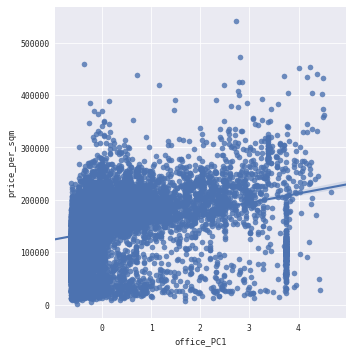

In [56]:
sns.lmplot(x="office_PC1", y="price_per_sqm", data=train)
plt.show()

It seems to be doing something. <i><b> Something </b></i>

Total TRC Variables: 12


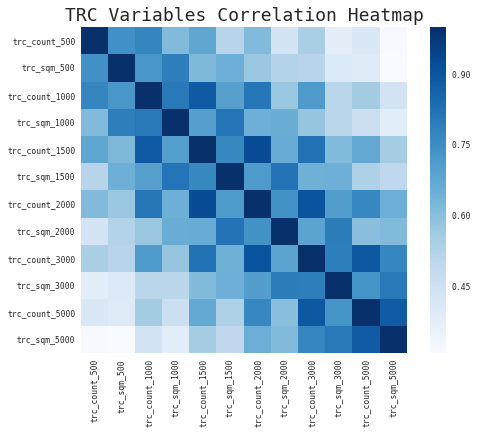

In [57]:
# List out the office variables and create a new dataframe for them
trc_variables = [x for x in list(train) if 'trc' in x]
print("Total TRC Variables:", len(trc_variables))
train_trc = train[trc_variables]
train_trc = train_trc.fillna(0)
# Correlation Matrix
trc_corr = train_trc.corr()
# Set up the matplotlib figure
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(8, 6))
# Draw the heatmap
sns.heatmap(trc_corr, vmax=1.0, square=True, cmap="Blues")
plt.title("TRC Variables Correlation Heatmap", fontsize=18)
plt.show()

Correlation heatmaps are definitely the prettiest charts out there. 

In [58]:
from sklearn.decomposition import PCA
#Let's see how many principal components are needed for capturing different amounts of variance in the data
pca50, pca90, pca95, pca99, pca9999 = PCA(n_components=0.5,whiten=True),PCA(n_components=0.9,whiten=True),PCA(n_components=0.95,whiten=True), PCA(n_components=0.99,whiten=True),PCA(n_components=0.9999,whiten=True)
pca50.fit(train_trc), pca90.fit(train_trc), pca95.fit(train_trc), pca99.fit(train_trc), pca9999.fit(train_trc)
print("PCs needed for 50% of variance:",np.shape(pca50.components_)[0])
print("PCs needed for 90% of variance:",np.shape(pca90.components_)[0])
print("PCs needed for 95% of variance:",np.shape(pca95.components_)[0])
print("PCs needed for 99% of variance:",np.shape(pca99.components_)[0])
print("PCs needed for 99.99% of variance:",np.shape(pca9999.components_)[0])

PCs needed for 50% of variance: 1
PCs needed for 90% of variance: 2
PCs needed for 95% of variance: 2
PCs needed for 99% of variance: 4
PCs needed for 99.99% of variance: 6


In [59]:
train_trc_pcs = pca95.transform(train_trc)
train = train.assign(trc_PC1= train_trc_pcs[:,0], trc_PC2= train_trc_pcs[:,1])

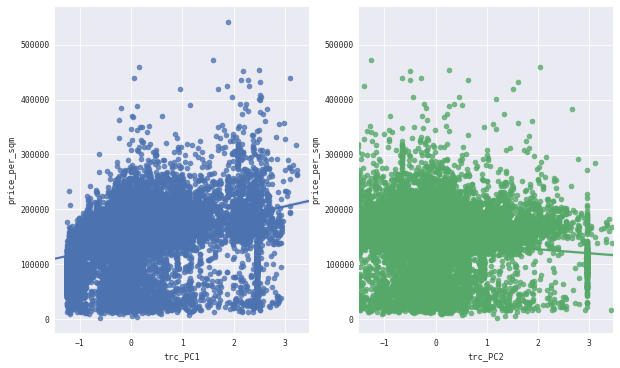

In [60]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
sns.regplot(x="trc_PC1", y="price_per_sqm", data=train, ax=axes[0])
sns.regplot(x="trc_PC2", y="price_per_sqm", data=train, ax=axes[1])
plt.show()

#### Let's see how the sub-area price depends on cafes and offices (their principal components, rather)

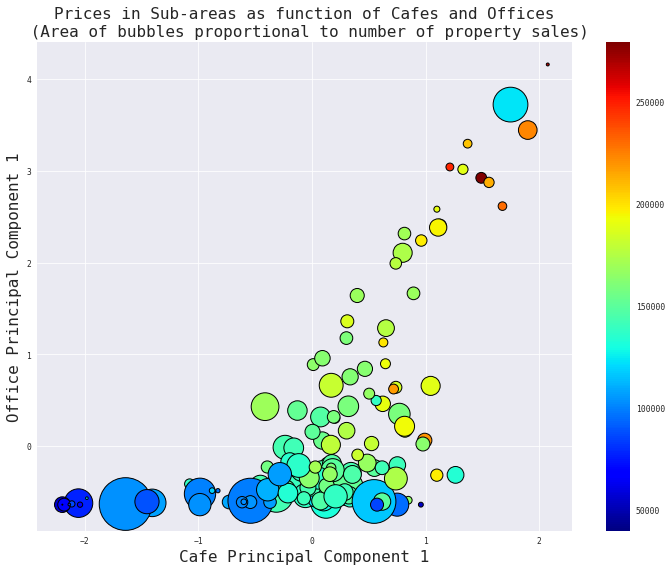

In [61]:
area_df = train[['sub_area','price_per_sqm','kremlin_km','area_m','cafe_PC1','office_PC1','trc_PC1']]
area_df['count'] = 1
area_group = area_df.groupby(['sub_area']).agg({'price_per_sqm':'mean', 'cafe_PC1':'mean', 'office_PC1':'mean', 'count':'sum'})
area_group['sub_area'] = np.array(area_group.index)
import matplotlib.cm as cm
plt.figure(figsize=(12,9))
sc =plt.scatter(x=area_group['cafe_PC1'], y=area_group['office_PC1'],
            s=area_group['count']**1.2, c=area_group['price_per_sqm'], 
            cmap = cm.jet, edgecolor='black', linewidth='1', marker='o')
plt.xlabel("Cafe Principal Component 1", fontsize=16)
plt.ylabel("Office Principal Component 1", fontsize=16)
plt.title("Prices in Sub-areas as function of Cafes and Offices\n (Area of bubbles proportional to number of property sales)", fontsize=16)
plt.colorbar(sc)
plt.show(sc)

## All the population variables

There are several population variables in the dataset and they are all correlated as well -- More men would naturally imply more women (may or may not be proportionate but still highly correlated). But the general observation for me in the cities that I have lived in is that younger working class folks fresh out of college don't mind staying in places which may not be very hip or may be far away from the business districts -- as long as they are cheap. Middle aged people prefer areas with more amenities like schools and less travelling time to workplaces. These localities are naturally more expensive. 

Let's observe if this hypothesis holds true and if it is a valuable price indicator. 

Total Population Variables: 28


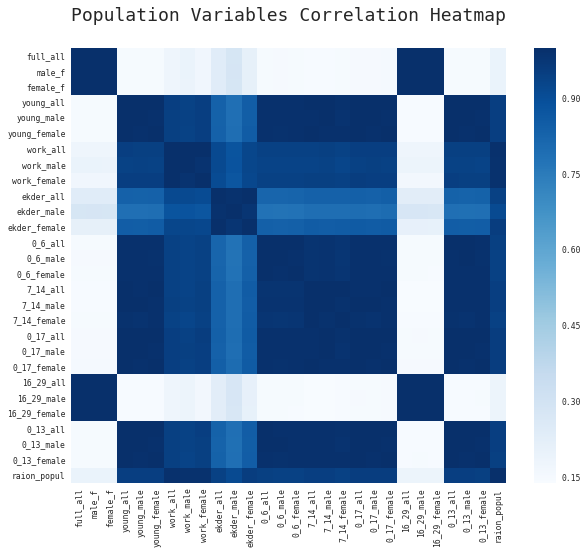

In [62]:
pop_variables = ['full_all','male_f','female_f','young_all','young_male','young_female','work_all',
                'work_male','work_female','ekder_all','ekder_male','ekder_female','0_6_all', 
                '0_6_male','0_6_female','7_14_all','7_14_male','7_14_female', '0_17_all',
                '0_17_male','0_17_female','16_29_all','16_29_male','16_29_female','0_13_all',
                '0_13_male','0_13_female','raion_popul']
train_pop = train[pop_variables]
print("Total Population Variables:", len(pop_variables))
train_pop = train_pop.fillna(0)
# Correlation Matrix
pop_corr = train_pop.corr()
# Set up the matplotlib figure
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(pop_corr, vmax=1.0, square=True, cmap="Blues")
plt.title("Population Variables Correlation Heatmap\n", fontsize=18)
plt.show()

The heatmap is a bit surprising. The 16-29 age group variables are highly correlated with the full_population variables but nothing else. Let's PCA again and see what we get.

In [63]:
from sklearn.decomposition import PCA
#Let's see how many principal components are needed for capturing different amounts of variance in the data
pca50, pca90, pca95, pca99, pca9999 = PCA(n_components=0.5,whiten=True),PCA(n_components=0.9,whiten=True),PCA(n_components=0.95,whiten=True), PCA(n_components=0.99,whiten=True),PCA(n_components=0.9999,whiten=True)
pca50.fit(train_pop), pca90.fit(train_pop), pca95.fit(train_pop), pca99.fit(train_pop), pca9999.fit(train_pop)
print("PCs needed for 50% of variance:",np.shape(pca50.components_)[0])
print("PCs needed for 90% of variance:",np.shape(pca90.components_)[0])
print("PCs needed for 95% of variance:",np.shape(pca95.components_)[0])
print("PCs needed for 99% of variance:",np.shape(pca99.components_)[0])
print("PCs needed for 99.99% of variance:",np.shape(pca9999.components_)[0])

PCs needed for 50% of variance: 1
PCs needed for 90% of variance: 1
PCs needed for 95% of variance: 1
PCs needed for 99% of variance: 2
PCs needed for 99.99% of variance: 5


#### One PC to rule them all?

Yup. I shall keep only one PC, but will also calculate some other variables like population density, sex ratio etc before dumping the raw variables

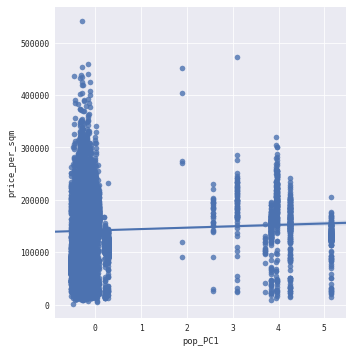

In [64]:
train_pop_pc = pca95.transform(train_pop)
train = train.assign(pop_PC1= np.ravel(train_pop_pc))

sns.lmplot(x="pop_PC1", y="price_per_sqm", data=train)
plt.show()

# Time Trends

Well we know for a fact that the Moscow real estate market saw a boom in 2014 and eventually cooled in late 2015. Is this seen in the data as well? Can potential overpriced outliers be dumped before being fed into the downstream regressor?

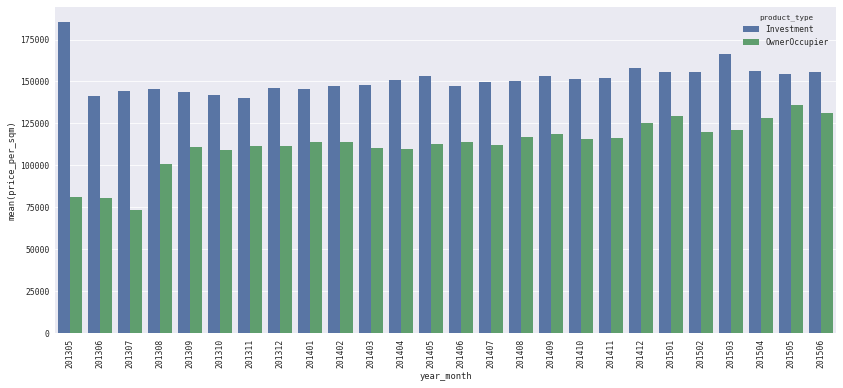

In [65]:
year_str = [str(x) for x in year]
month_str = [str(x) for x in month]
year_month = np.array([int(x+y) if int(y)>9 else int(x+'0'+y) for (x,y) in zip(year_str, month_str)])
train['year_month'] = year_month

time_df = train[['year_month','price_per_sqm','product_type','price_doc']]
time_df['count'] = 1
time_group = time_df.groupby(['year_month','product_type']).agg({'price_per_sqm':'mean', 'price_doc':'mean', 'count':'count'})
time_group = time_group.reset_index()
f, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x="year_month",y="price_per_sqm", data=time_group, hue="product_type")
plt.xticks(rotation=90)
plt.show()
#time_group

Just what's wrong with OwnerOccupied properties before 2012/08?? I believe this is serious data capture errors - either price_doc or full_sq. Either way, these datapoints need to be thrown away. Data like this can send the model completely off-track. THIS IS REALLY FRUSTRATING.

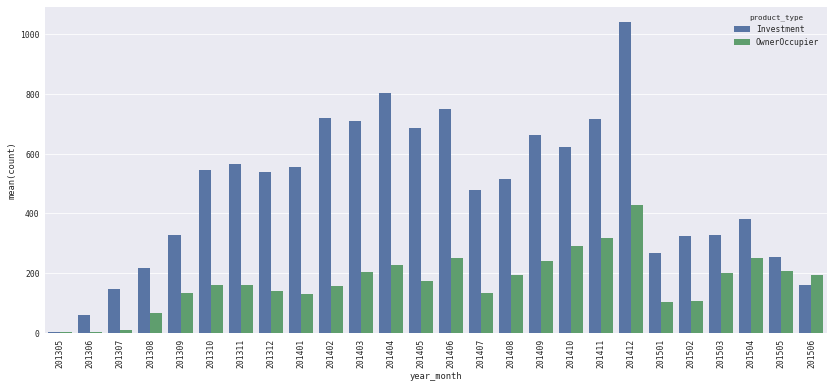

In [66]:
f, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x="year_month",y="count", data=time_group, hue="product_type")
plt.xticks(rotation=90)
plt.show()

There sin't much data about Owner Occupied houses for months prior to 2012/08 --> We won't lose too many data points by dumping those